# CS3319-02 Lab 2

## **Task1：Count Min Sketch**

Count Min Sketch (CMS) is an efficient algorithm in processing large streams. CMS can estimate the frequency of each type of elements in the stream. In this coding, you're given the `stream_data.txt` (binary stream), and you need to implement the CMS algorithm to count the number of 1-bits. Write code below.

### 1. Set the size of hashset to 1000, the depth(number) of hash function to 5, and count the number of 1-bits in the whole stream.

In [1]:
import numpy as np
import hashlib

In [2]:
# Your code here, you can add cells if necessary

width = 1000
depth = 5

file_path = '/kaggle/input/streaming/stream_data.txt'

with open(file_path, 'r') as file:
    binary_stream = file.read().strip()

def get_hash_functions(num_hashes, max_val):
    def hash_function_factory(i):
        def hash_function(x):
            return int(hashlib.md5((str(i) + x).encode('utf-8')).hexdigest(), 16) % max_val
        return hash_function
    
    return [hash_function_factory(i) for i in range(num_hashes)]


class CountMinSketch:
    def __init__(self, width, depth):
        self.width = width
        self.depth = depth
        self.table = np.zeros((depth, width), dtype=int)
        self.hash_functions = get_hash_functions(depth, width)

    def add(self, item):
        for i, hash_func in enumerate(self.hash_functions):
            index = hash_func(item)
            self.table[i][index] += 1

    def count(self, item):
        min_count = float('inf')
        for i, hash_func in enumerate(self.hash_functions):
            index = hash_func(item)
            min_count = min(min_count, self.table[i][index])
        return min_count
    

cms = CountMinSketch(width, depth)

# Add all bits to the Count Min Sketch
for bit in binary_stream:
    cms.add(bit)

# Count the number of 1-bits in the whole stream using CMS
one_bits_count_cms = cms.count('1')
one_bits_count_cms


15868

### 2. Set the size of hashset and the depth(number) of hash function to your liking, and count the number of 1-bits in the whole stream.

In [3]:
# Your code here, you can add cells if necessary

width = 3
depth = 2
cms = CountMinSketch(width, depth)

# Add all bits to the Count Min Sketch
for bit in binary_stream:
    cms.add(bit)

# Count the number of 1-bits in the whole stream using CMS
one_bits_count_cms = cms.count('1')
one_bits_count_cms

15868

### 3. Write a function that accurately counts the number of 1-bits in the current window. Caculate the accuracy of your own CMS algorithm and compare the running time difference.

In [4]:
# Your code here, you can add cells if necessary
import time
def count_accurate_1_bits(binary_stream):
    return binary_stream.count('1')

# Accurate count
accurate_count = count_accurate_1_bits(binary_stream)

# CMS count
cms_count = cms.count('1')

print("Accurate count of 1-bits:", accurate_count)
print("CMS estimated count of 1-bits:", cms_count)

accuracy = (cms_count / accurate_count) * 100
print("Accuracy of CMS:", accuracy, "%")

# Compare running time
start_time_accurate = time.time()
accurate_count = count_accurate_1_bits(binary_stream)
end_time_accurate = time.time()

start_time_cms = time.time()
cms_count = cms.count('1')
end_time_cms = time.time()

print("Running time for accurate count:", end_time_accurate - start_time_accurate)
print("Running time for CMS count:", end_time_cms - start_time_cms)

Accurate count of 1-bits: 15868
CMS estimated count of 1-bits: 15868
Accuracy of CMS: 100.0 %
Running time for accurate count: 0.0003819465637207031
Running time for CMS count: 0.0001327991485595703


## **Task2：Bloom Filter**

A Bloom filter is a space-efficient probabilistic data structure. Here the task is to implement a bloom filter by yourself. 

### Data loading

From the NLTK (Natural Language ToolKit) library, we import a large list of English dictionary words, commonly used by the very first spell-checking programs in Unix-like operating systems.

In [5]:
import nltk
from nltk.corpus import words
word_list = words.words()

Then we load another dataset from the NLTK Corpora collection: movie_reviews.

The movie reviews are categorized between positive and negative, so we construct a list of words (usually called bag of words) for each category.

In [6]:
from nltk.corpus import movie_reviews

neg_reviews = []
pos_reviews = []

for fileid in movie_reviews.fileids('neg'):
    neg_reviews.extend(movie_reviews.words(fileid))
for fileid in movie_reviews.fileids('pos'):
    pos_reviews.extend(movie_reviews.words(fileid))

In [7]:
pos_reviews[0:10]

['films',
 'adapted',
 'from',
 'comic',
 'books',
 'have',
 'had',
 'plenty',
 'of',
 'success']

Here we get a data stream (word_list) and 2 query lists (neg_reviews and pos_reviews).

### 1. Write a function that accurately determines whether each word in neg_reviews and pos_reviews belongs to word_list.

In [8]:
# Your code here, you can add cells if necessary
from tqdm import tqdm

def is_in_word_list(word_list, reviews):
    res = []
    for word in tqdm(reviews, total=len(reviews), desc="linear search"):
        if word in word_list:
            res.append(word)
    return res

def judge_in(word_list,reviews):
    res = []
    for i in  tqdm(range(len(reviews)), desc="judging"):
        res.append(reviews[i] in word_list)
    return res


# neg_reviews_in_word_list = is_in_word_list(word_list, neg_reviews)
# pos_reviews_in_word_list = is_in_word_list(word_list, pos_reviews)

# print("Number of words in word_list:", len(word_list))
# print("Number of negative review words in word_list:", len(neg_reviews_in_word_list))
# print("Number of positive review words in word_list:", len(pos_reviews_in_word_list))

# judges = judge_in(word_list, neg_reviews)



 ### 2. Implement the bloom filter by yourself and add all words in word_list in your bloom filter. Compare the running time difference between linear search on a list and multiple hash computations in a Bloom filter.

In [9]:
# Your code here, you can add cells if necessary

class BloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = np.zeros(size, dtype=bool)
        self.hash_functions = self._generate_hash_functions()

    def _generate_hash_functions(self):
        def hash_function_factory(i):
            def hash_function(x):
                return int(hashlib.md5((str(i) + x).encode('utf-8')).hexdigest(), 16) % self.size
            return hash_function
        
        return [hash_function_factory(i) for i in range(self.hash_count)]
    
    def add(self, item):
        for hash_func in self.hash_functions:
            index = hash_func(item)
            self.bit_array[index] = True
    
    def check(self, item):
        return all(self.bit_array[hash_func(item)] for hash_func in self.hash_functions)

# Initialize Bloom filter
bloom_filter_size = 500000
hash_count = 7
bloom_filter = BloomFilter(bloom_filter_size, hash_count)

# Add all words to the Bloom filter
for word in tqdm(word_list, desc="adding words to bloom filter..."):
    bloom_filter.add(word)


# Function to perform linear search
def linear_search(words_list, review):
    return judge_in(words_list, review)

def bloom_search(words_list, reviews):
    res = []
    for word in tqdm(reviews, total=len(reviews), desc="bloom search"):
        res.append(bloom_filter.check(word))
    return res

adding words to bloom filter...: 100%|██████████| 236736/236736 [00:05<00:00, 45666.95it/s]


In [10]:
import time
# Measure time for linear search on positive reviews
start_time_linear_pos = time.time()
result_linear_pos = linear_search(word_list, pos_reviews)
end_time_linear_pos = time.time()

# Measure time for Bloom filter check on positive reviews
start_time_bloom_pos = time.time()
result_bloom_pos = bloom_search(word_list, pos_reviews)
end_time_bloom_pos = time.time()

# Measure time for linear search on negative reviews
start_time_linear_neg = time.time()
result_linear_neg = linear_search(word_list, neg_reviews)
end_time_linear_neg = time.time()

# Measure time for Bloom filter check on negative reviews
start_time_bloom_neg = time.time()
result_bloom_neg = bloom_search(word_list, neg_reviews)
end_time_bloom_neg = time.time()

print("Linear search on positive reviews result count:", len(result_linear_pos))
print("Bloom filter check on positive reviews result count:", len(result_bloom_pos))
print("Running time for linear search on positive reviews:", end_time_linear_pos - start_time_linear_pos)
print("Running time for Bloom filter check on positive reviews:", end_time_bloom_pos - start_time_bloom_pos)

print("Linear search on negative reviews result count:", len(result_linear_neg))
print("Bloom filter check on negative reviews result count:", len(result_bloom_neg))
print("Running time for linear search on negative reviews:", end_time_linear_neg - start_time_linear_neg)
print("Running time for Bloom filter check on negative reviews:", end_time_bloom_neg - start_time_bloom_neg)

bloom search: 100%|██████████| 751256/751256 [00:16<00:00, 45710.67it/s]

Linear search on positive reviews result count: 832564
Bloom filter check on positive reviews result count: 832564
Running time for linear search on positive reviews: 2321.315118789673
Running time for Bloom filter check on positive reviews: 18.212610960006714
Linear search on negative reviews result count: 751256
Bloom filter check on negative reviews result count: 751256
Running time for linear search on negative reviews: 2103.355593919754
Running time for Bloom filter check on negative reviews: 16.439258337020874


### 3. Use different bit array length `m` and number of hash functions `k` to implement the bloom filter algorithm. Then compare the impact of different `m` and `k` on the false positive rate.

m = 200000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 96274.52it/s]
checking words: 832564it [00:09, 89350.29it/s]


fp on pos 221778


checking words: 751256it [00:08, 89953.86it/s]


fp on neg 200757
fp 0.26678221009963254
m = 200000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 44815.27it/s]
checking words: 832564it [00:19, 43256.35it/s]


fp on pos 232319


checking words: 751256it [00:17, 43567.93it/s]


fp on neg 210140
fp 0.27936192244068137
m = 200000, k = 11


adding words: 100%|██████████| 236736/236736 [00:07<00:00, 29954.58it/s]
checking words: 832564it [00:28, 29137.78it/s]


fp on pos 232426


checking words: 751256it [00:25, 28908.25it/s]


fp on neg 210252
fp 0.2795001957293127
m = 200000, k = 15


adding words: 100%|██████████| 236736/236736 [00:11<00:00, 21146.92it/s]
checking words: 832564it [00:38, 21839.21it/s]


fp on pos 232436


checking words: 751256it [00:34, 21512.81it/s]


fp on neg 210258
fp 0.2795102978873862
m = 300000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 97195.20it/s]
checking words: 832564it [00:08, 93714.05it/s]


fp on pos 170136


checking words: 751256it [00:08, 91794.53it/s]


fp on neg 153148
fp 0.20411662941495878
m = 300000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 45277.63it/s]
checking words: 832564it [00:18, 44461.09it/s]


fp on pos 229265


checking words: 751256it [00:17, 43442.12it/s]


fp on neg 207292
fp 0.2756354888813123
m = 300000, k = 11


adding words: 100%|██████████| 236736/236736 [00:08<00:00, 28926.26it/s]
checking words: 832564it [00:28, 28989.33it/s]


fp on pos 232343


checking words: 751256it [00:25, 29060.31it/s]


fp on neg 210214
fp 0.2794237981588817
m = 300000, k = 15


adding words: 100%|██████████| 236736/236736 [00:10<00:00, 22211.47it/s]
checking words: 832564it [00:38, 21747.23it/s]


fp on pos 232428


checking words: 751256it [00:34, 21613.94it/s]


fp on neg 210257
fp 0.2795046154234698
m = 400000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 96986.04it/s]
checking words: 832564it [00:09, 87530.92it/s]


fp on pos 144855


checking words: 751256it [00:08, 93108.59it/s]


fp on neg 130069
fp 0.17358285663774925
m = 400000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 46279.81it/s]
checking words: 832564it [00:18, 45317.97it/s]


fp on pos 169867


checking words: 751256it [00:16, 45101.81it/s]


fp on neg 156793
fp 0.20624818476847118
m = 400000, k = 11


adding words: 100%|██████████| 236736/236736 [00:08<00:00, 29159.71it/s]
checking words: 832564it [00:29, 28603.11it/s]


fp on pos 230606


checking words: 751256it [00:26, 28852.44it/s]


fp on neg 208184
fp 0.27704537131744766
m = 400000, k = 15


adding words: 100%|██████████| 236736/236736 [00:11<00:00, 21051.45it/s]
checking words: 832564it [00:39, 21041.21it/s]


fp on pos 232305


checking words: 751256it [00:35, 21162.00it/s]


fp on neg 210147
fp 0.2793575027465242
m = 500000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 99297.50it/s]
checking words: 832564it [00:08, 95056.74it/s]


fp on pos 71594


checking words: 751256it [00:07, 94281.29it/s]


fp on neg 64543
fp 0.08595484335341137
m = 500000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 46079.74it/s]
checking words: 832564it [00:18, 45516.31it/s]


fp on pos 162182


checking words: 751256it [00:16, 45572.11it/s]


fp on neg 143784
fp 0.19318230607013423
m = 500000, k = 11


adding words: 100%|██████████| 236736/236736 [00:07<00:00, 29983.95it/s]
checking words: 832564it [00:29, 28271.43it/s]


fp on pos 223659


checking words: 751256it [00:25, 29090.44it/s]


fp on neg 201788
fp 0.2686208028690129
m = 500000, k = 15


adding words: 100%|██████████| 236736/236736 [00:10<00:00, 21938.55it/s]
checking words: 832564it [00:38, 21652.31it/s]


fp on pos 230843


checking words: 751256it [00:34, 21597.10it/s]


fp on neg 208887
fp 0.2776388731042669
m = 600000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 97265.40it/s]
checking words: 832564it [00:08, 92999.77it/s]


fp on pos 90682


checking words: 751256it [00:08, 93279.08it/s]


fp on neg 79336
fp 0.10734679445896629
m = 600000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 44775.82it/s]
checking words: 832564it [00:18, 45675.51it/s]


fp on pos 135430


checking words: 751256it [00:16, 46383.75it/s]


fp on neg 126262
fp 0.16522837191094947
m = 600000, k = 11


adding words: 100%|██████████| 236736/236736 [00:07<00:00, 29656.85it/s]
checking words: 832564it [00:28, 29316.21it/s]


fp on pos 217619


checking words: 751256it [00:25, 29350.75it/s]


fp on neg 197012
fp 0.26179174401131444
m = 600000, k = 15


adding words: 100%|██████████| 236736/236736 [00:10<00:00, 21953.19it/s]
checking words: 832564it [00:39, 21213.25it/s]


fp on pos 228460


checking words: 751256it [00:34, 21753.27it/s]


fp on neg 206941
fp 0.27490560796050056
m = 700000, k = 3


adding words: 100%|██████████| 236736/236736 [00:02<00:00, 98037.79it/s]
checking words: 832564it [00:08, 95274.05it/s]


fp on pos 119404


checking words: 751256it [00:08, 93210.64it/s]


fp on neg 106692
fp 0.14275359573688928
m = 700000, k = 7


adding words: 100%|██████████| 236736/236736 [00:05<00:00, 45455.73it/s]
checking words: 832564it [00:17, 46260.27it/s]


fp on pos 140968


checking words: 751256it [00:16, 45584.77it/s]


fp on neg 126810
fp 0.16907098028816406
m = 700000, k = 11


adding words: 100%|██████████| 236736/236736 [00:07<00:00, 29957.50it/s]
checking words: 832564it [00:27, 30168.00it/s]


fp on pos 181758


checking words: 751256it [00:25, 28947.61it/s]


fp on neg 163703
fp 0.21811885188973495
m = 700000, k = 15


adding words: 100%|██████████| 236736/236736 [00:10<00:00, 22212.65it/s]
checking words: 832564it [00:37, 21912.81it/s]


fp on pos 221608


checking words: 751256it [00:34, 21907.04it/s]


fp on neg 201368
fp 0.2670606508315339


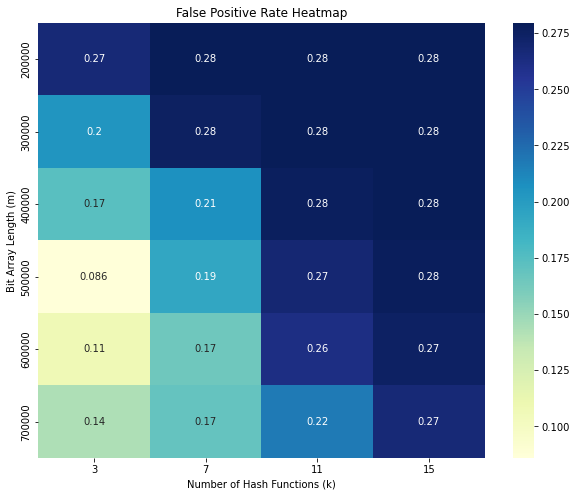

In [12]:
# Your code here, you can add cells if necessary
import random

gt_pos = result_linear_pos # len(pos_reviews), True if word in word_list
gt_neg = result_linear_neg

import random
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_false_positive_rate(bloom_filter, word_list, gt):
    false_positives = 0
    for i, word in tqdm(enumerate(word_list), desc="checking words"):
        if bloom_filter.check(word) and not gt[i]:
            false_positives += 1
    return false_positives


# Different configurations for m and k
m_values = [200000,300000, 400000, 500000, 600000, 700000]
k_values = [3, 7, 11, 15]
false_positive_rates = np.zeros((len(m_values), len(k_values)))

# Ground truth for positive and negative reviews
gt_pos = result_linear_pos
gt_neg = result_linear_neg

for i, m in enumerate(m_values):
    for j, k in enumerate(k_values):
        print(f"m = {m}, k = {k}")
        del bloom_filter
        bloom_filter = BloomFilter(m, k)
        for word in tqdm(word_list, desc="adding words"):
            bloom_filter.add(word)
        
        # Calculate false positive rate on test set
        false_positive_cnt_on_pos = calculate_false_positive_rate(bloom_filter,pos_reviews, gt_pos)
        print("fp on pos", false_positive_cnt_on_pos)
        false_positive_cnt_on_neg = calculate_false_positive_rate(bloom_filter,neg_reviews, gt_neg)
        print("fp on neg", false_positive_cnt_on_neg)
        false_positive_rate = (false_positive_cnt_on_pos + false_positive_cnt_on_neg) / (len(gt_pos) + len(gt_neg))
        print("fp", false_positive_rate)
        false_positive_rates[i, j] = false_positive_rate

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(false_positive_rates, annot=True, xticklabels=k_values, yticklabels=m_values, cmap='YlGnBu')
plt.title('False Positive Rate Heatmap')
plt.xlabel('Number of Hash Functions (k)')
plt.ylabel('Bit Array Length (m)')
plt.show()

